ECE 792 - Advanced Topics in Machine Learning

Homework 4
 
Submitted by - Surya Dutta (SID: 200481187)

In [19]:
# Import all necessary libraries
import numpy as np
import math
import matplotlib.pyplot as plt
import argparse
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as functional
from pathlib import Path
import pandas as pd
from torch.utils.data import DataLoader

# Set the default to double precision numbers
torch.set_default_dtype(torch.float64) 

In [20]:
# Load Google Drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [21]:
# Define the Affine Coupling Transformation Class
class Affine_Coupling(nn.Module):
    # Initialize
    def __init__(self, mask, hidden_dim):
        super(Affine_Coupling, self).__init__()
        self.input_dim = len(mask)
        self.hidden_dim = hidden_dim

        # Define mask
        self.mask = nn.Parameter(mask, requires_grad = False)

        # Define the scaling layers in the Affine Coupling Transformation
        self.scale_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.scale_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.scale_fc3 = nn.Linear(self.hidden_dim, self.input_dim)
        self.scale = nn.Parameter(torch.Tensor(self.input_dim))
        init.normal_(self.scale)

        # Define the translation layers in the Affine Coupling Transformation 
        self.translation_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.translation_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.translation_fc3 = nn.Linear(self.hidden_dim, self.input_dim)

    # Compute the scaling factor and the translation factor
    def _compute_scale(self, x):
        s = torch.relu(self.scale_fc1(x*self.mask))
        s = torch.relu(self.scale_fc2(s))
        s = torch.relu(self.scale_fc3(s)) * self.scale        
        return s

    def _compute_translation(self, x):       
        t = torch.relu(self.translation_fc1(x*self.mask))
        t = torch.relu(self.translation_fc2(t))
        t = self.translation_fc3(t)        
        return t
    
    # Forward Function
    def forward(self, x):
        # Convert the latent space variable to an observed variable and returns the log of the determinant
        s = self._compute_scale(x)
        t = self._compute_translation(x)
        y = self.mask*x + (1-self.mask)*(x*torch.exp(s) + t)        
        logdet = torch.sum((1 - self.mask)*s, -1) 
        return y, logdet 

    # Inverse Function - Maps the Gaussian distribution to the distribution of choice
    def inverse(self, y):
        s = self._compute_scale(y)
        t = self._compute_translation(y)
        x = self.mask*y + (1-self.mask)*((y - t)*torch.exp(-s))
        logdet = torch.sum((1 - self.mask)*(-s), -1)
        return x, logdet

In [22]:
class Normalizing_Flow(nn.Module):
    def __init__(self, num_layers, hidden_dim):
        super(Normalizing_Flow, self).__init__()        
        self.hidden_dim = hidden_dim

        # Define the Mask according to the number of layers
        if num_layers == 1:
          masks = [[1.0, 0.0]]
        elif num_layers == 3:
          masks = [[1.0, 0.0],
                   [0.0,1.0],
                   [1.0,0.0]]
        elif num_layers == 5:
          masks = [[1.0, 0.0],
                   [0.0,1.0],
                   [1.0,0.0],
                   [0.0,1.0],
                   [1.0,0.0]]

        # Distribution of the latent space
        self.masks = nn.ParameterList(
            [nn.Parameter(torch.Tensor(m),requires_grad = False)
             for m in masks])

        self.affine_couplings = nn.ModuleList(
            [Affine_Coupling(self.masks[i], self.hidden_dim)
             for i in range(len(self.masks))])

    # Forward Function    
    def forward(self, x):
        y = x
        logdet_tot = 0
        for i in range(len(self.affine_couplings)):
            y, logdet = self.affine_couplings[i](y)
            logdet_tot = logdet_tot + logdet

        # Normalization Layer
        logdet = torch.sum(torch.log(torch.abs(4*(1-(torch.tanh(y))**2))), -1)        
        y = 4*torch.tanh(y)
        logdet_tot = logdet_tot + logdet
        
        return y, logdet_tot

    def inverse(self, y):      
        x = y        
        logdet_tot = 0
        # Inverse the Normalization Layer
        logdet = torch.sum(torch.log(torch.abs(1.0/4.0* 1/(1-(x/4)**2))), -1)
        x  = 0.5*torch.log((1+x/4)/(1-x/4))
        logdet_tot = logdet_tot + logdet
        # Inverse the Affine Coupling Transformation Layer
        for i in range(len(self.affine_couplings)-1, -1, -1):
            x, logdet = self.affine_couplings[i].inverse(x)
            logdet_tot = logdet_tot + logdet    
        return x, logdet_tot

In [23]:
# Set up training and testing directories

train_dir = "/content/gdrive/MyDrive/DATA/moons_train.csv"
test_dir = "/content/gdrive/MyDrive/DATA/moons_test.csv"
#train_dir = "/content/gdrive/MyDrive/DATA/circles_train.csv"
#test_dir = "/content/gdrive/MyDrive/DATA/circles_test.csv"

# Read train and test data
train_data = pd.read_csv(train_dir)
test_data = pd.read_csv(test_dir)

# Convert DataFrame to Numpy array
train_data= np.array([train_data['x1'],train_data['x2']]).T
test_data= np.array([test_data['x1'],test_data['x2']]).T

In [31]:
# Convert to Tensor
train_tensor = torch.tensor(train_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

# Set up Train and Test DataLoaders
train_dataloader = DataLoader(train_tensor, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_tensor, batch_size=128, shuffle=False)

In [38]:
# Define Hyperparameters
hidden_dim = 128
num_layers = 5

# Create the object
Normalizing_Flow = Normalizing_Flow(num_layers, hidden_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Normalizing_Flow.to(device)

# Set up the optimizer with choice of learning rate
optimizer = optim.Adam(Normalizing_Flow.parameters(), lr = 0.00001)

# Define the number of epochs
num_steps = 100

# Define arrays to capture the model training losses
ep = []
loss_ep = []

# Training Loop
for idx_step in range(num_steps):
  for batch_id ,batch in enumerate(train_dataloader):
      batch = batch.to(device)
      z, logdet = Normalizing_Flow.inverse(batch)
      # Calculate the negative loglikelihood of X
      loss = torch.log(z.new_tensor([2*math.pi])) + torch.mean(torch.sum(0.5*z**2, -1) - logdet)
      optimizer.zero_grad() # Make the gradients 0 
      loss.backward() # Backpropagation
      optimizer.step()

  # Plot the progress
  if (idx_step + 1) % 5 == 0:
    ep.append(idx_step)
    loss_ep.append(loss.item())
    print(f"idx_steps: {idx_step:}, loss: {loss.item():.5f}")
        

idx_steps: 4, loss: 2.27605
idx_steps: 9, loss: 1.30768
idx_steps: 14, loss: 1.26982
idx_steps: 19, loss: 1.22765
idx_steps: 24, loss: 1.18709
idx_steps: 29, loss: 1.14625
idx_steps: 34, loss: 1.10960
idx_steps: 39, loss: 1.07899
idx_steps: 44, loss: 1.05037
idx_steps: 49, loss: 1.02948
idx_steps: 54, loss: 1.01974
idx_steps: 59, loss: 1.00867
idx_steps: 64, loss: 1.00201
idx_steps: 69, loss: 1.00431
idx_steps: 74, loss: 1.00981
idx_steps: 79, loss: 1.00428
idx_steps: 84, loss: 0.99528
idx_steps: 89, loss: 0.97087
idx_steps: 94, loss: 0.95564
idx_steps: 99, loss: 0.93483


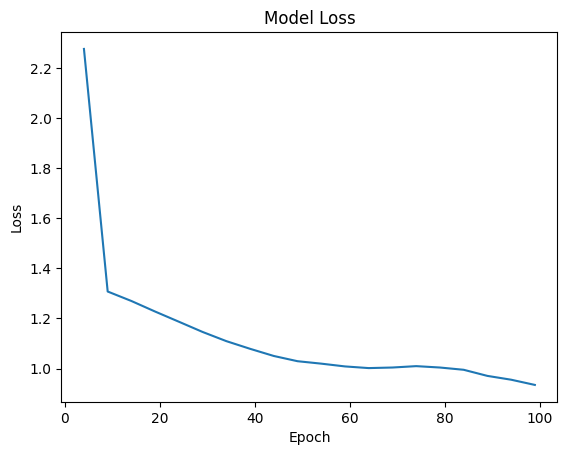

In [40]:
# Plot the model loss
plt.plot(ep, loss_ep)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

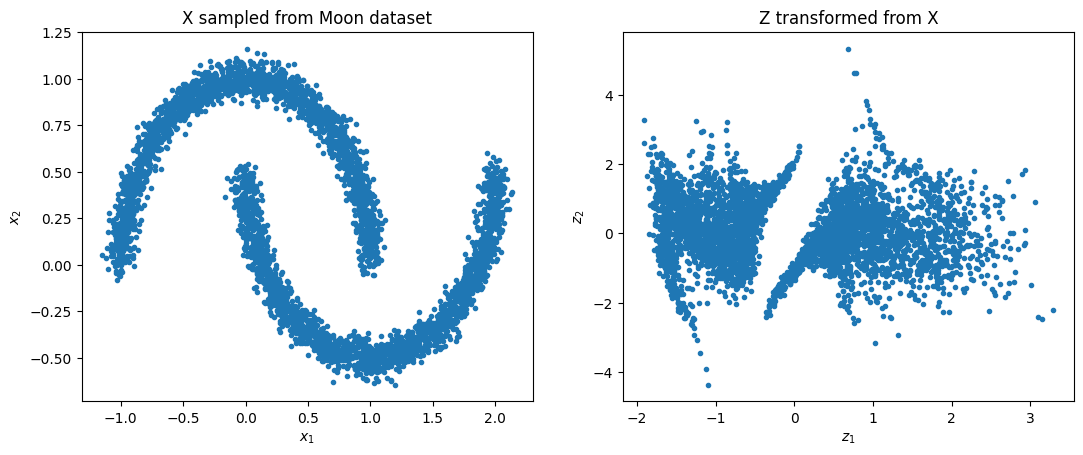

In [39]:
# Plots
# Check if the model can transform from the Inferred Data Space X to the Inferred Latent Space Z
X = train_data
X = torch.Tensor(X).to(device = device)
z, logdet_jacobian = Normalizing_Flow.inverse(X)
z = z.cpu().detach().numpy()

X = X.cpu().detach().numpy()
fig = plt.figure(2, figsize = (12.8, 4.8))
fig.clf()
plt.subplot(1,2,1)
plt.plot(X[:, 0], X[:, 1], ".")
plt.title("X sampled from the dataset")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.subplot(1,2,2)
plt.plot(z[:, 0], z[:, 1], ".")
plt.title("Z transformed from X")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.show()

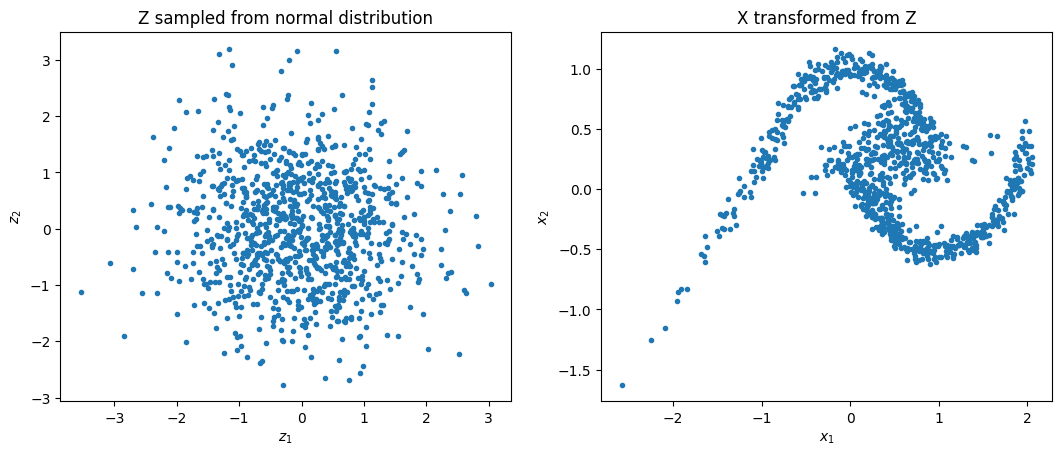

In [41]:
# Plots
# Check if the model can transform from Z to X
z = torch.normal(0, 1, size = (1000, 2)).to(device = device)
X, _ = Normalizing_Flow(z)
X = X.cpu().detach().numpy()
z = z.cpu().detach().numpy()

fig = plt.figure(2, figsize = (12.8, 4.8))
fig.clf()
plt.subplot(1,2,1)
plt.plot(z[:,0], z[:,1], ".")
plt.title("Z sampled from the normal distribution")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")

plt.subplot(1,2,2)
plt.plot(X[:,0], X[:,1], ".")
plt.title("X transformed from Z")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.show()

In [42]:
# Generating Latent Space
# Define the dimensionality of the latent space 
latent_dim = 2
# Define the number of points to generate
num_points = 1000
# Create a random noise tensor
z = torch.randn((num_points, latent_dim)).to(device)
# Pass the noise tensor through the forward method of the RealNVP model to generate the new points
x_hat, _ = Normalizing_Flow.forward(z)
# Detach the generated points from the computation graph and move them to CPU for visualization
x_hat = x_hat.cpu().detach().numpy()

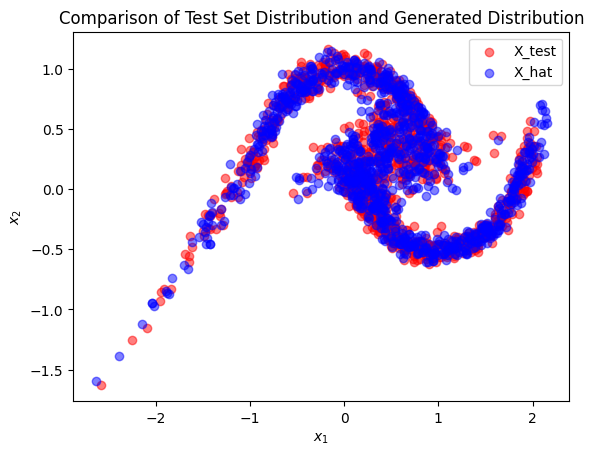

In [43]:
# Plot the scatter plot of x from the test set
# Remember to changing train_dir and run the model again
plt.scatter(X[:, 0], X[:, 1], color='red', alpha=0.5, label='X_test')

# Plot the scatter plot of x_hat 
plt.scatter(x_hat[:, 0], x_hat[:, 1], color='blue', alpha=0.5, label='X_hat')

plt.title("Comparison of Test Set Distribution and Generated Distribution")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()
plt.show()